# An Analysis and Breakdown of League of Legends Matches
By Oliver Wu

# Introduction

League of Legends (LoL) is a Multiplayer Online Battle Arena (MOBA) game developed by Riot Games. It is one of the most popular computer games in the world, and especially so in Asia. The core idea of the game is relatively simple. The map is a square divided in half diagonally into two sides by a "river", representing the two teams, each containing five players. There are three "lanes" and a "jungle" inbetween the lanes representing a a free roam area. Each lane has three towers pre team, and in the center of a teams base, they have two towers defending their "nexus". The first team to destroy the other team's nexus first wins.

While the core idea of the game is simple, the games themselves are incredibly complex. There are over 150+ characters, or champions to chose in the game, along with dozens of different items to chose. There are so many different ways to customize the combinations of champions items, and spells, runes, and numerous other factors that there is no one way to win the game. A big part of the reason for why I've been playing this game for almost 7 years now is that the game is constantly updated with new features, which helps to make each and every match feel unique and different from the last.

The dataset I chose to use is a list of over 50,000 ranked matches collected on the European West server using the official Riot Games API service. The data was collected on patch 7.17.2. For reference, the first number of a patch always represents the current season, meaning that this data was collected in season 7. The game is currently on season 12, meaning this data is about 5 years old. The dataset can be reached [here]( https://www.kaggle.com/datasets/datasnaek/league-of-legends)

This goal of this tutorial is to narrow down this extremely large amount of data into smaller more bite sized chunks that can be analyzed in different parts. There are so many different ways to approach the data given, such as analyzing which team tends to win after getting first baron buff, or which color side wins, or even which champions tend to win more. I want to analyze the different data we have and see if we are able to predict a win in League of Legends using the data.

**Note**: There a quite a few terms that are used interchangablely with this game, in this section I will keep a list of these terms for the sake of consistency.

League of Legends = LoL

Characters = Champions

Game = Match*

*_I'm electing to use the term match to describe one individual play session as game can represent both the video game itself and the play session_



# Importing Libraries
Here we are going to import all of the libraries we need to scrape, process the data, and create figures using it!

In [16]:
import pandas as pd #https://pandas.pydata.org/docs/
import numpy as np #https://numpy.org/doc/
import matplotlib.pyplot as plt #https://matplotlib.org/
from sklearn.linear_model import LinearRegression #https://scikit-learn.org/stable/
from statsmodels.formula.api import ols #https://www.statsmodels.org/stable/index.html

# Reading the Dataset

In our first step, we're going to read in the data from the CSV file provided using Pandas into a Pandas Dataframe

In [2]:
games = pd.read_csv("games.csv", sep = ",")
games.head()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18


As you can see 61 columns means that theres a LOT of data being tracked here. While it may seem trivial, I want to very quickly summarize what each column is exactly tracking, and if it is a more advanced game concept, I'll include a link to the League of Legends wiki to help clarify the definition. This will help us determine which columns will be relevant to our data analysis

**gameId**: This value is a unique number to represent the match played

**creationTime**: The time calculated in milliseconds that the match between the 10 players was created

**gameDuration**: The duration of the game in seconds

**seasonId**: The current season number

**winner**: The team that won the game. (1 = Team 1, 2 = Team 2)

**firstBlood**: The team that got the first kill of the game. (1 = Team 1, 2 = Team 2)

**firstTower**: The team that destroyed the first tower of the game. (1 = Team 1, 2 = Team 2). [wiki](https://leagueoflegends.fandom.com/wiki/Kill)

**firstInhibitor**: The team that destroyed the first inhibitor of the game. (1 = Team 1, 2 = Team 2) [wiki](https://leagueoflegends.fandom.com/wiki/Inhibitor)

**firstBaron**: The team that slayed the first Baron Nashor of the game. (0 = No team, 1 = Team 1, 2 = Team 2) [wiki](https://leagueoflegends.fandom.com/wiki/Baron_Nashor_(League_of_Legends))

**firstDragon**: The team that slayed the first Dragon of the game. (0 = No team, 1 = Team 1, 2 = Team 2) [wiki](https://leagueoflegends.fandom.com/wiki/Dragon)

**firstRiftHerald**: The team that slayed the first Rift Herald of the game. (0 = No Team, 1 = Team 1, 2 = Team 2) [wiki](https://leagueoflegends.fandom.com/wiki/Rift_Herald_(League_of_Legends))

The rest of the columns follow a similar pattern, so instead of going through each one, I'll explain the naming scheme and explain the variances

**t#_champ#id**: The unique identifier representing the champion that the first player on Team 1 picked. The first number is either 1 or 2 representing the team. The second number is 1-5 representing the player

**t#_champ#_sum#**: The unique identifier representing the summoner spell that the first player on Team 1 picked. The first number is either 1 or 2 representing the team. The second number is 1-5 representing the player. The third number is 1 or 2 representing the first or second summoner spell the player picked (each player gets two summoner spells)

**t#_towerKills**: The total number of towers the team has taken down. The first number is either 1 or 2 representing the team.

**t#_inhibitorKills**: The total number of inhibitors the team has taken down. The first number is either 1 or 2 representing the team.

**t#_baronKills**: The total number of barons the team has slain. The first number is either 1 or 2 representing the team.

**t#_dragonKills**: The total number of dragons the team has slain. The first number is either 1 or 2 representing the team.

**t#_riftHeraldKills**: The total number of rift heralds the team has slain. The first number is either 1 or 2 representing the team.

**t#_ban#**: The champion ID for the first champion the team banned. The first number is either 1 or 2 representing the team. The second number is 1-5 representing the numbered ban (each team gets 5). [wiki](https://leagueoflegends.fandom.com/wiki/Draft_Pick)


# Data Tidying Part 1
Now that we've finished labeling each column, we can remove some of the unimportant data. I'm going to remove the meta data about the game itself (creationTime, seasonID) as this data is larely irrelevant in the actual gameplay. The first parameter is the string of the column name, the 'inplace' is asking us if we want to create a new dataframe or if we want to modify the current dataframe, 'axis' is specifying the column or row of the dataframe (1 is column, 2 is row)

In [3]:
#games.drop('gameId', inplace = True, axis = 1)
games.drop('creationTime', inplace = True, axis = 1)
games.drop('seasonId', inplace = True, axis = 1)
display(games.head())

#This is done to check if theres any missing values in our dataset. If it returns false, we do not need to handle missing data
print(games.isnull().values.any())


,gameId,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1949,1,2,1,1,1,1,2,8,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1851,1,1,1,1,0,1,1,119,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1493,1,2,1,1,1,2,0,18,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1758,1,1,1,1,1,1,0,57,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,2094,1,2,1,1,1,1,0,19,...,3,0,0,1,0,86,11,201,122,18


False


As you can probably see, we didn't really narrow the data down that much, a measly two columns were dropped, still leaving us with 59 columns. One approach to further tidying the data would be to combine some of the columns. However, I want to avoid that approach as a lot of the data in the dataset is represented by ID's which could create a lot more complexity that I would like to avoid. Another idea is to divide this dataset into three smaller datasets. The first dataset is going to be titled **draft**, representing all of the factors set during the initial draft phase of the game (champions, summoner spells, bans). The second dataset is going to titled **objectives**, representing tasks completed in the game (first blood, first tower, first inhibitor, first baron, first dragon, first rift herald, tower kills, inhibitor kills, baron kills, dragon kills, rift herald kills)

# Data Tidying Part 2

In [4]:
objectives = games[['winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills']]
draft = games[['winner', 't1_champ1id', 't1_champ1_sum1', 't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id', 't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1', 't1_champ5_sum2', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2', 't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id', 't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1', 't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5']]
#Extract the necessary columns from the games DataFrame
display(objectives.head())
display(draft.head())

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills
0,1,2,1,1,1,1,2,11,1,2,3,0,5,0,0,1,1
1,1,1,1,1,0,1,1,10,4,0,2,1,2,0,0,0,0
2,1,2,1,1,1,2,0,8,1,1,1,0,2,0,0,1,0
3,1,1,1,1,1,1,0,9,2,1,2,0,0,0,0,0,0
4,1,2,1,1,1,1,0,9,2,1,3,0,3,0,0,1,0


,winner,t1_champ1id,t1_champ1_sum1,t1_champ1_sum2,t1_champ2id,t1_champ2_sum1,t1_champ2_sum2,t1_champ3id,t1_champ3_sum1,t1_champ3_sum2,...,t2_champ4_sum1,t2_champ4_sum2,t2_champ5id,t2_champ5_sum1,t2_champ5_sum2,t1_ban1,t1_ban2,t1_ban3,t1_ban4,t1_ban5
0,1,8,12,4,432,3,4,96,4,7,...,14,4,412,4,3,92,40,69,119,141
1,1,119,7,4,39,12,4,76,4,3,...,4,14,92,4,7,51,122,17,498,19
2,1,18,4,7,141,11,4,267,3,4,...,4,11,22,7,4,117,40,29,16,53
3,1,57,4,12,63,4,14,29,4,7,...,4,14,22,4,7,238,67,516,114,31
4,1,19,4,12,29,11,4,40,4,3,...,4,12,51,4,7,90,64,412,25,31


We now have much smaller datasets to work with and are seperated by their respective categories as well to reduce a lot of clutter. I elected to keep the winner in both of the datasets so we could analyze which team won based off of what conditions.

# Initial Analysis

I'm going to start with some extremely simple analysis. First Blood is a stat that tracks the team that gets the first kill of the game. It gives the earning team 100 extra gold. Its actual relevance to winning a game has been questioned for a long time, so lets take a look with our data!

# First Blood to Win Ratio


In [18]:
totalMatches = len(objectives.index)
numWinner = 0
for index, row in objectives.iterrows():
    if objectives.at[index, 'winner'] == objectives.at[index, 'firstBlood']: #Check for all instances where the team that earned First Blood was the Winner
        numWinner = numWinner + 1
print("First Blood Winrate: " + str(numWinner/totalMatches*100)) 

First Blood Winrate: 58.471547873373474


Checking through all of the matches, we can see that the team that gets first blood wins an average of 58.47% of games. Cool, this information really doesn't tell us much at all. Lets add some data to compare!

# Adding More Objectives
Next I want to compare all of the "first" objectives to see if we can get a more well-rounded coorleation to see if the team that successfully completes a task on the map first is able to translate into more wins.

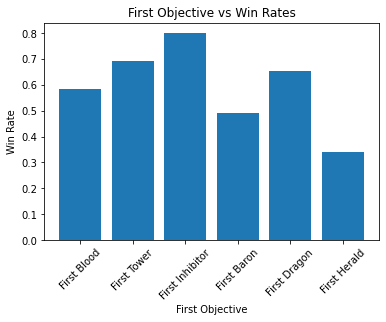

In [6]:
numWinnerBlood = numWinner
numWinnerTower = 0
numWinnerInhibitor = 0
numWinnerBaron = 0
numWinnerDragon = 0
numWinnerHerald = 0
for index, row in objectives.iterrows():
    if objectives.at[index, 'winner'] == objectives.at[index, 'firstTower']: #Check for all instances where the team that earned First Tower was the Winner
        numWinnerTower = numWinnerTower + 1
    if objectives.at[index, 'winner'] == objectives.at[index, 'firstInhibitor']: #Check for all instances where the team that earned First Inhibitor was the Winner
        numWinnerInhibitor = numWinnerInhibitor + 1
    if objectives.at[index, 'winner'] == objectives.at[index, 'firstBaron']: #Check for all instances where the team that earned First Baron was the Winner
        numWinnerBaron = numWinnerBaron + 1
    if objectives.at[index, 'winner'] == objectives.at[index, 'firstDragon']: #Check for all instances where the team that earned First Dragon was the Winner
        numWinnerDragon = numWinnerDragon + 1
    if objectives.at[index, 'winner'] == objectives.at[index, 'firstRiftHerald']:#Check for all instances where the team that earned First RiftHerald was the Winner
        numWinnerHerald = numWinnerHerald + 1 

numWinnerBlood = numWinnerBlood/totalMatches
numWinnerTower = numWinnerTower/totalMatches
numWinnerInhibitor = numWinnerInhibitor/totalMatches
numWinnerBaron = numWinnerBaron/totalMatches
numWinnerDragon = numWinnerDragon/totalMatches
numWinnerHerald = numWinnerHerald/totalMatches
x = ['First Blood', 'First Tower', 'First Inhibitor', 'First Baron', 'First Dragon', 'First Herald']
y = [numWinnerBlood, numWinnerTower, numWinnerInhibitor, numWinnerBaron, numWinnerDragon, numWinnerHerald]

plt.bar(x, y)
plt.xticks(rotation = 45)
plt.xlabel("First Objective")
plt.ylabel("Win Rate")
plt.title("First Objective vs Win Rates")
plt.show()


Adding in the other objectives gave us a lot more data to look at. Before we actually analyze the data, I want to give some quick context on what parts of the games these objectives tend to happen. A LoL game is typically divided into three sections, the Early Game, the Mid Game, and the Late Game. These are exactly as they sound and represents different time points in the game. While there are no exact values for what consititutes each section of the game, some extremely approximate values to use for reference are the following: Early game 0-15 Minutes, Mid Game 16-30 minutes, Late Game 31+ Minutes into the game. First Blood almost always occurs early into the game. First Tower tends to occur at the end of early game and going into mid game. First Inhibitor in the middle of mid game, first baron later in mid game, first dragon in the middle of early game, and first herald in the middle of early game. The later in the game a objective is taken, the more importance it has towards winning a game.

Immediately we can see that the team that gets the first Rift Herald of the game has a very low win rate at 34.14%. On the other hand, the team that gets the first Inhibitor Tower has a 80% win rate. First Blood tends to almost always be the first objective that occurs in a game of LoL. I believe thats why it should be used as a frame of reference. As we discussed before, First Blood resulted in a 58.47% win rate. Surprisingly, even though First Blood occurs so early in the game, it still results in a higher win rate than an objective like Baron which is one of the most major objectives in the game, which only results in a 48.94% win rate. First Dargon, another very early objective is boasts a honestly astonishing 65.39% win rate. First tower, another early objective also boasts a higher win rate than expected.

As we can see, theres a lot of variation on the results. Mid-Late game objectives don't necessarily result in wins, and Early game objectives can highly contribute to a higher win rate as well. This is exactly what I wanted to discuss about LoL! Win rates are not determined by linear factors.



# Exploring other routes

Unfortunately, this path is pretty limited, and theres not much more we can explore with solely objectives. Looking at all of the other data available, basing wins off of summoner spells is trivial, as one summoner spell is almost always the same for every player on the team. Number of objectives could be a worthwhile path to approach, however, faces a problem of certain factors not tracked by our dataset. For example, with something like Baron kills, we do not know how many subsequent towers were taken by that team after that Baron was slain. 

Its clear that our objectives dataset is likely not going to get us any further with our hypothesis.

But what about our draft dataset?
Bans is another one of those stats that requires extra information to know its relevancy in our win that its not worth pursuing in this case. However, champion picks has incredible potential for both determining a win, and predicting a win.

# Data Tidying Part 3

Now that we're focusing on champion picks, the data is going to need to be retided to remove all unecessary data.

In [7]:
champions = games[['winner', 't1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id', 't2_champ1id', 't2_champ2id', 't2_champ3id', 't2_champ4id', 't2_champ5id']]
champions.head()

,winner,t1_champ1id,t1_champ2id,t1_champ3id,t1_champ4id,t1_champ5id,t2_champ1id,t2_champ2id,t2_champ3id,t2_champ4id,t2_champ5id
0,1,8,432,96,11,112,104,498,122,238,412
1,1,119,39,76,10,35,54,25,120,157,92
2,1,18,141,267,68,38,69,412,126,24,22
3,1,57,63,29,61,36,90,19,412,92,22
4,1,19,29,40,119,134,37,59,141,38,51


Now that the table is setup, the next step is to replace the champion IDs with the champion names. While this step isn't necessary, it will help to make our chart be more readable.


In [8]:
championData = pd.read_json("champion_info_2.json") #json file including data mapping champion names to IDs
champInfo = pd.read_json((championData['data']).to_json(), orient = 'index')
ID_Dictionary = pd.Series(champInfo.key.values, index = champInfo.id).to_dict()
print(ID_Dictionary)

{266: 'Aatrox', 103: 'Ahri', 84: 'Akali', 12: 'Alistar', 32: 'Amumu', 34: 'Anivia', 1: 'Annie', 22: 'Ashe', 136: 'AurelionSol', 268: 'Azir', 432: 'Bard', 53: 'Blitzcrank', 63: 'Brand', 201: 'Braum', 51: 'Caitlyn', 164: 'Camille', 69: 'Cassiopeia', 31: 'Chogath', 42: 'Corki', 122: 'Darius', 131: 'Diana', 36: 'DrMundo', 119: 'Draven', 245: 'Ekko', 60: 'Elise', 28: 'Evelynn', 81: 'Ezreal', 9: 'Fiddlesticks', 114: 'Fiora', 105: 'Fizz', 3: 'Galio', 41: 'Gangplank', 86: 'Garen', 150: 'Gnar', 79: 'Gragas', 104: 'Graves', 120: 'Hecarim', 74: 'Heimerdinger', 420: 'Illaoi', 39: 'Irelia', 427: 'Ivern', 40: 'Janna', 59: 'JarvanIV', 24: 'Jax', 126: 'Jayce', 202: 'Jhin', 222: 'Jinx', 429: 'Kalista', 43: 'Karma', 30: 'Karthus', 38: 'Kassadin', 55: 'Katarina', 10: 'Kayle', 141: 'Kayn', 85: 'Kennen', 121: 'Khazix', 203: 'Kindred', 240: 'Kled', 96: 'KogMaw', 7: 'Leblanc', 64: 'LeeSin', 89: 'Leona', 127: 'Lissandra', 236: 'Lucian', 117: 'Lulu', 99: 'Lux', 54: 'Malphite', 90: 'Malzahar', 57: 'Maokai', 11:

Now that we have a dictionary of Keys = Champion IDs and Values = Champion Names, we can now replace the champion IDs in our champions DataFrame

In [9]:
 pd.options.mode.chained_assignment = None

for index, row in champions.iterrows():
    champions.at[index, 't1_champ1id'] = ID_Dictionary[champions.loc[index, 't1_champ1id']]
    champions.at[index, 't1_champ2id'] = ID_Dictionary[champions.loc[index, 't1_champ2id']]
    champions.at[index, 't1_champ3id'] = ID_Dictionary[champions.loc[index, 't1_champ3id']]
    champions.at[index, 't1_champ4id'] = ID_Dictionary[champions.loc[index, 't1_champ4id']]
    champions.at[index, 't1_champ5id'] = ID_Dictionary[champions.loc[index, 't1_champ5id']]
    champions.at[index, 't2_champ1id'] = ID_Dictionary[champions.loc[index, 't2_champ1id']]
    champions.at[index, 't2_champ2id'] = ID_Dictionary[champions.loc[index, 't2_champ2id']]
    champions.at[index, 't2_champ3id'] = ID_Dictionary[champions.loc[index, 't2_champ3id']]
    champions.at[index, 't2_champ4id'] = ID_Dictionary[champions.loc[index, 't2_champ4id']]
    champions.at[index, 't2_champ5id'] = ID_Dictionary[champions.loc[index, 't2_champ5id']]
champions.head()

,winner,t1_champ1id,t1_champ2id,t1_champ3id,t1_champ4id,t1_champ5id,t2_champ1id,t2_champ2id,t2_champ3id,t2_champ4id,t2_champ5id
0,1,Vladimir,Bard,KogMaw,MasterYi,Viktor,Graves,Xayah,Darius,Zed,Thresh
1,1,Draven,Irelia,Nidalee,Kayle,Shaco,Malphite,Morgana,Hecarim,Yasuo,Riven
2,1,Tristana,Kayn,Nami,Rumble,Kassadin,Cassiopeia,Thresh,Jayce,Jax,Ashe
3,1,Maokai,Brand,Twitch,Orianna,DrMundo,Malzahar,Warwick,Thresh,Riven,Ashe
4,1,Warwick,Twitch,Janna,Draven,Syndra,Sona,JarvanIV,Kayn,Kassadin,Caitlyn


The next step is a little more difficult. For each champion, we need to calculate the individual win rate of that champion across all 50,000+ games.

In [10]:
d = 0
winrates = pd.Series(data = d, index = pd.Series(ID_Dictionary).values)
pressence = champions.stack().value_counts() #Count all of the times a chamion appears
wins = pd.Series(data = d, index = pd.Series(ID_Dictionary).values)

pressence.drop([1, 2], inplace = True) #Number of games the champion appeared in
wins.drop(['None'], inplace = True) #Number of games the champion won
winrates.drop(['None'], inplace = True) #Wins/Pressence

print(pressence)

Thresh         13002
Tristana       12983
Vayne          10658
Kayn            9853
LeeSin          9188
               ...  
Ryze            1032
Karthus         1007
AurelionSol      841
Aatrox           753
Skarner          574
Length: 138, dtype: int64


In [21]:
team1 = champions[['winner', 't1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id']]
team2 = champions[['winner', 't2_champ1id', 't2_champ2id', 't2_champ3id', 't2_champ4id', 't2_champ5id']]
team1 = team1[team1['winner'] == 1]
team2 = team2[team2['winner'] == 2]

team1.reset_index(drop = True, inplace = True)
team2.reset_index(drop = True, inplace = True)

display(team1)
display(team2)

team1 = team1.stack().value_counts() #Organize team1 DataFrame
team2 = team2.stack().value_counts() #Organize team2 DataFrame
display(team2)

team1.drop([1], inplace = True)
team2.drop([2], inplace = True)

for k, v in wins.items():
    wins[k] = team1[k] + team2[k] #Combine all win amounts

for k, v in winrates.items():
    winrates[k] = wins[k] / pressence[k] * 100 #Calculate winrates
    
display(winrates)


2              25413
Tristana        3292
Thresh          3065
Vayne           2726
Kayn            2316
               ...  
Lissandra        243
AurelionSol      238
Ryze             203
Aatrox           171
Skarner          142
Length: 139, dtype: int64

Aatrox     47.011952
Ahri       52.169094
Akali      50.322143
Alistar    49.597238
Amumu      50.951557
             ...    
Zac        49.202552
Zed        49.365325
Ziggs      51.534803
Zilean     49.207443
Zyra       49.893843
Length: 138, dtype: float64

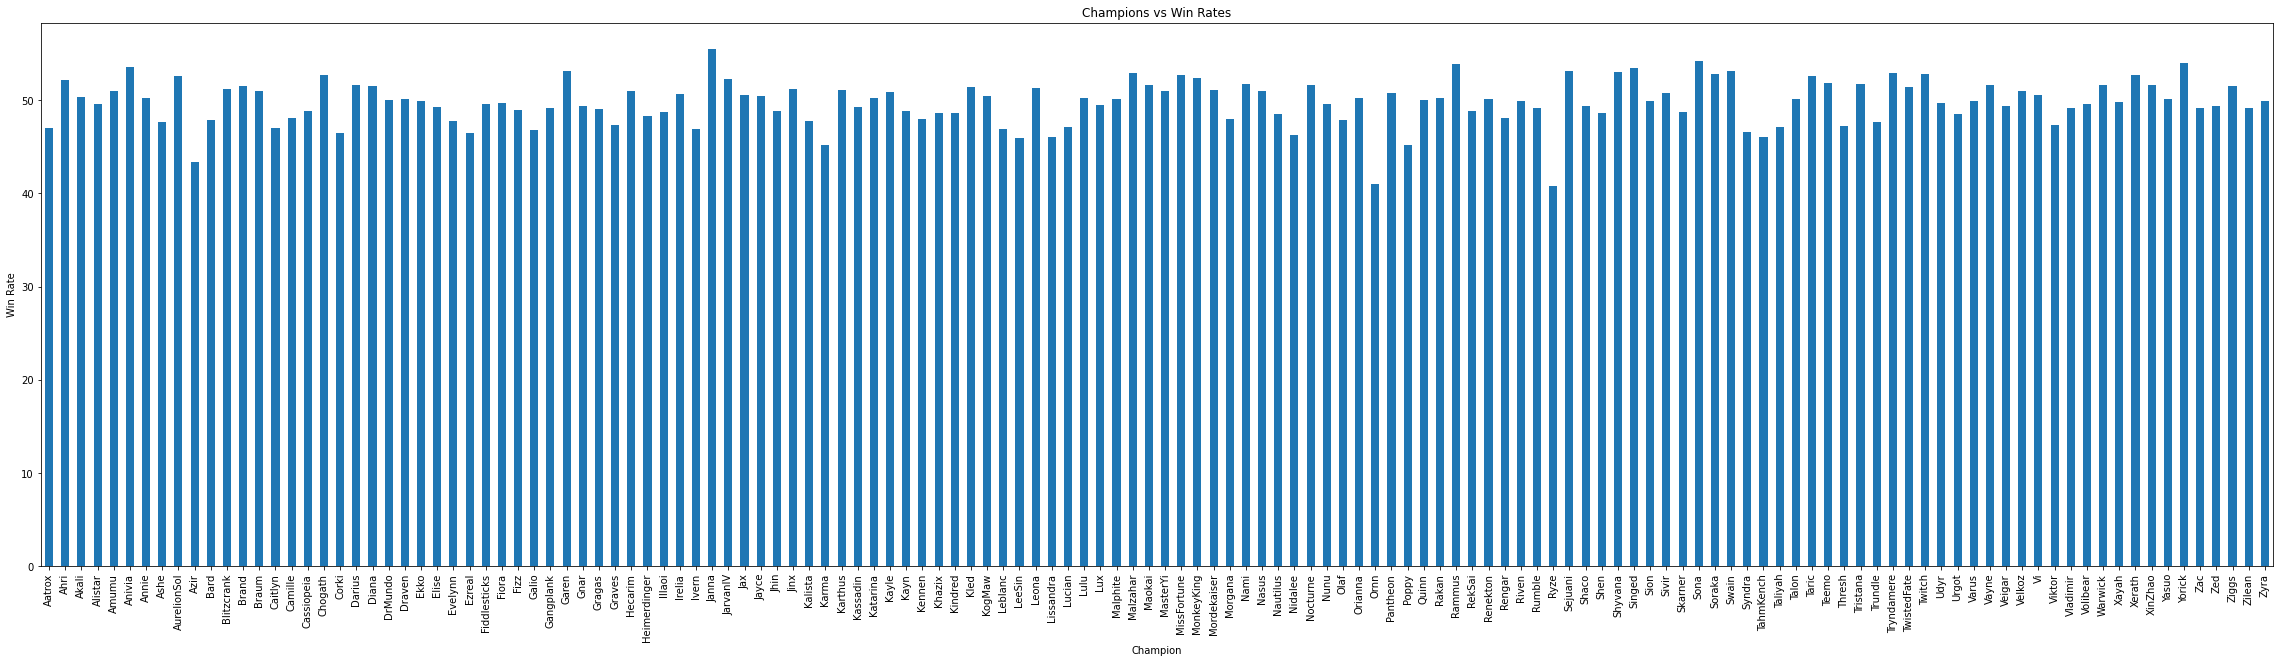

In [12]:
winrates.plot.bar(figsize=(40, 10))
plt.xlabel("Champion")
plt.ylabel("Win Rate")
plt.title("Champions vs Win Rates")
plt.show()

As we can see from our bar graph, most of the champions hover around a 50% winrate, which signals that overall most champions in the game are in a mostly equalized state. Not too strong, and not too weak. However, there are some outliers, such as Quinn, Ryze, and Azir who are doing especially poorly, hovering around close to a 40% winrate. These champions as such are likely slated for positive changes, or buffs in a near-future patch as they are considered struggling. Other champions such as Jarvan IV, Renekton, and Yorick are hovering closer to a 60% win rate. These champions opposite to the three mentioned earlier, are likely slated for negative changes, or nerfs in a near-future patch as they are considered too strong. Riot games uses winrates heavily as a metric for determining whether or not a champion needs to be changed between different patches (updates) to the game. As such, winrates will very tend heavily from patch to patch. As such, I want to clarify that this information, and subsequent prediction are only valid for patch 7.17.2.

Great! Now we have the winrates of every champion, but how can we expand on this data? We pretty much eliminated every other column data available...except for one forgotten one. Game duration. Game duration is a perfect piece of data to compare with champion win rates, as many champions are stronger at different points in the game. So lets refine our question. Given a champion, and a game duration, can we predict the win

# Creating the Model

Now its time to setup our model:


In [13]:
d = {'champions': winrates.keys(), 'winrates': winrates.values}
winratesdf = pd.DataFrame(data = d)

model = ols('winrates ~ champions', data = winratesdf).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               winrates   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 16 May 2022   Prob (F-statistic):                nan
Time:                        12:34:33   Log-Likelihood:                 3907.2
No. Observations:                 138   AIC:                            -7538.
Df Residuals:                       0   BIC:                            -7134.
Df Model:                         137                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1751: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1751: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1673: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


What happened? Why is there a bunch of missing values, infinitys, and divide by zero errors? Well, unforunately, this is a the end of the line of this hypothesis. The way this data is setup is that for each champion we have an associated winrate value. However, this provides no training data for the linear regression model to work on. Okay, but what if we just inputed all of the champions in and used the winner column to see which champion combinations win. This could theoretically work, but is held back by the binary nature of the winner column, leading to the necessary usage of a more complex logistical regression model, which even then wouldn't exactly give us the results we desired. The other main problem is that not every champion appears in every game, so a lot of the data ends up not working for a lot of the champions. One solution would be to focus on one specific champion, but that again would limit our possible data. As such, its time to rethink and switch to a different hypothesis.

You're probably wondered why I wasted so much time going through this hypothesis just to show in the end why we couldn't make a model of it. The point of this was mainly to show why certain models don't work as they might seem and that a lot of thinking and adaption to a dataset is what is necessary to get results for a hypothesis on a dataset

# Pivioting Towards a New Model

Not all is lost here. First, I want to think about what exactly made the last hypothesis not work for our model. It was the binary nature of the "winner" column. Due to it only having two states, it made it hard to make a worthwhile and working model of it. As such, a solution would be to find a more quantitative data value. Looking through all of the columns, theres an obvious answer that's been missed: Game Duration. Game Duration is a great value to work with as its quantitative, and every single game has a game duration. Furthermore, its something interesting to think about as few people think about how champions affect match duration. So for our new hypothesis, lets ask, whether the champions and champion combinations in a match of LoL affect the duration of a game?

In [14]:
champions2 = games[['gameDuration', 't1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id', 't2_champ1id', 't2_champ2id', 't2_champ3id', 't2_champ4id', 't2_champ5id']]
for index, row in champions2.iterrows():
    champions2.at[index, 't1_champ1id'] = ID_Dictionary[champions2.loc[index, 't1_champ1id']]
    champions2.at[index, 't1_champ2id'] = ID_Dictionary[champions2.loc[index, 't1_champ2id']]
    champions2.at[index, 't1_champ3id'] = ID_Dictionary[champions2.loc[index, 't1_champ3id']]
    champions2.at[index, 't1_champ4id'] = ID_Dictionary[champions2.loc[index, 't1_champ4id']]
    champions2.at[index, 't1_champ5id'] = ID_Dictionary[champions2.loc[index, 't1_champ5id']]
    champions2.at[index, 't2_champ1id'] = ID_Dictionary[champions2.loc[index, 't2_champ1id']]
    champions2.at[index, 't2_champ2id'] = ID_Dictionary[champions2.loc[index, 't2_champ2id']]
    champions2.at[index, 't2_champ3id'] = ID_Dictionary[champions2.loc[index, 't2_champ3id']]
    champions2.at[index, 't2_champ4id'] = ID_Dictionary[champions2.loc[index, 't2_champ4id']]
    champions2.at[index, 't2_champ5id'] = ID_Dictionary[champions2.loc[index, 't2_champ5id']]
champions2.head()

,gameDuration,t1_champ1id,t1_champ2id,t1_champ3id,t1_champ4id,t1_champ5id,t2_champ1id,t2_champ2id,t2_champ3id,t2_champ4id,t2_champ5id
0,1949,Vladimir,Bard,KogMaw,MasterYi,Viktor,Graves,Xayah,Darius,Zed,Thresh
1,1851,Draven,Irelia,Nidalee,Kayle,Shaco,Malphite,Morgana,Hecarim,Yasuo,Riven
2,1493,Tristana,Kayn,Nami,Rumble,Kassadin,Cassiopeia,Thresh,Jayce,Jax,Ashe
3,1758,Maokai,Brand,Twitch,Orianna,DrMundo,Malzahar,Warwick,Thresh,Riven,Ashe
4,2094,Warwick,Twitch,Janna,Draven,Syndra,Sona,JarvanIV,Kayn,Kassadin,Caitlyn


Reusing some code from above, we create a new DataFrame with gameDuration replacing winner, and we still put the string name for the champions in instead of the IDs for clarity.

Now to make the model:

In [15]:
model = ols('gameDuration ~ t1_champ1id + t1_champ2id + t1_champ3id + t1_champ4id + t1_champ5id + t2_champ1id + t2_champ2id + t2_champ3id + t2_champ4id + t2_champ5id', data = champions2).fit()
print('model r-squared: ' + str(model.rsquared))

model r-squared: 0.05056016819596498


The r-squared for our hypothesis is 5%, showing little to no coorelation for the linear regression.

What went wrong here? Well, the the most obvious answer is that there's little coorelation between champions picked and game duration. However, another very probable answer is that simply don't have enough data to make a signficant coorelation. With over 150 unique champions, and ten unique champion slots per game, theres an incredible number of combinations that 50,000 matches simply doesn't scratch. 

# Conclusion

You're probably asking why I chose this dataset despite not getting any significantly successful results? The answer is once again that I love how complex this game is, and how data science is not simply linear. There are so many different ways to look and analyze data, and sometimes the datasets you have might not work for certain types of analysis, while they accel at others. Sometimes the data shows exactly the coorelations you want, and sometimes it doesn't. This dataset shows that even though it had over 60 columns and 50,000 rows of data, we were still missing some parts that could potentially have resulted in a different hypothesis and a different conclusion. I urge you to try playing League of Legends yourself as well! While the game is not beginner friendly by any means, once you get past the early learning curve of the game, the strategy behind it becomes a great deal of fun! 